In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import cifar_data_utils
import semisupervised_vae_lib as ss_vae_lib

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F


In [2]:
seed = 13423
np.random.seed(seed)
_ = torch.manual_seed(seed)


# Load data

In [3]:
train_set_labeled, train_set_unlabeled, test_set = \
    cifar_data_utils.load_semisupervised_cifar_dataset(propn_sample=1.0, 
                                                      propn_labeled = 0.1)

| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified
| Preparing CIFAR-100 dataset...
Files already downloaded and verified


In [4]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  5000
num_train_unlabled:  45000
num_test:  10000


In [5]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

labels_legend_all = unpickle('../cifar100_data/cifar-100-python/meta')
fine_labels_legend = labels_legend_all[b'fine_label_names']

In [6]:
def plot_cifar_image(image, label):
    image_unscaled = image * cifar_data_utils.CIFAR_STD_TENSOR + cifar_data_utils.CIFAR_MEAN_TENSOR

    img = np.dstack((image_unscaled[0, :, :],
                            image_unscaled[1, :, :],
                            image_unscaled[2, :, :]))

    plt.imshow(img)
    plt.title(fine_labels_legend[label])

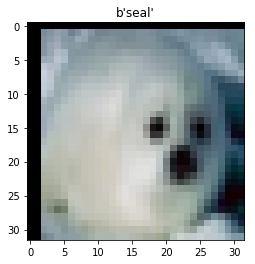

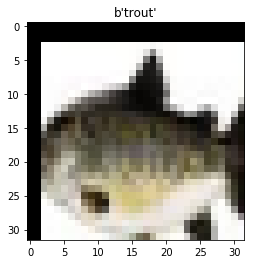

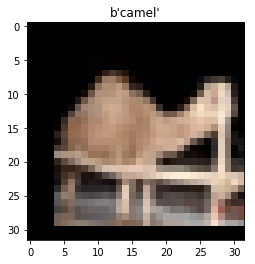

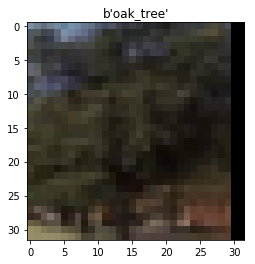

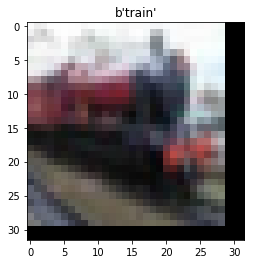

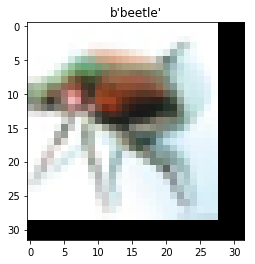

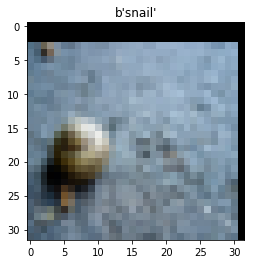

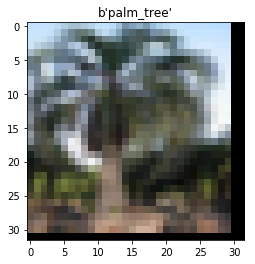

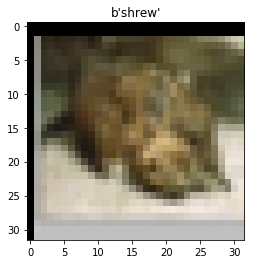

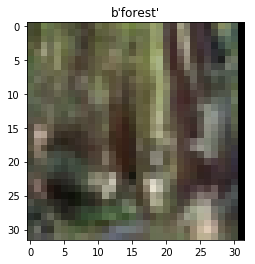

In [7]:
for i in range(10): 
    # train_set_labeled[i]['image']
    plt.figure()
    plot_cifar_image(train_set_labeled[i]['image'].squeeze(), train_set_labeled[i]['label'])

In [8]:
slen = train_set_labeled[0]['image'].shape[0]

# Get data loaders

In [9]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=train_set_labeled.num_images,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [10]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [11]:
data_unlabeled['image'].shape

torch.Size([12, 3, 32, 32])

In [12]:
data_labeled['image'].shape

torch.Size([5000, 3, 32, 32])

In [13]:
data_test['image'].shape

torch.Size([12, 3, 32, 32])

In [14]:
# check distribution 

In [15]:
unique, counts = np.unique(data_labeled['label'].numpy(), return_counts=True)

In [16]:
counts

array([49, 54, 54, 48, 60, 54, 59, 53, 46, 36, 52, 45, 58, 51, 41, 49, 45,
       61, 48, 63, 51, 43, 49, 65, 38, 46, 47, 50, 46, 57, 46, 54, 49, 54,
       43, 47, 56, 52, 42, 49, 50, 43, 53, 39, 39, 55, 61, 55, 75, 55, 60,
       57, 51, 45, 52, 49, 55, 42, 51, 46, 55, 50, 64, 45, 60, 43, 54, 42,
       43, 48, 39, 31, 54, 55, 54, 43, 48, 47, 47, 54, 45, 32, 50, 47, 58,
       64, 61, 45, 56, 46, 58, 50, 54, 45, 43, 40, 49, 45, 51, 42])

In [17]:
print(np.min(counts))

31


# Define VAE

In [18]:
latent_dim = 6
n_classes = 10

In [19]:
# vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

vae = mnist_vae_lib.get_mnist_vae(latent_dim = latent_dim, 
                    n_classes = n_classes, 
                   slen = slen)

NameError: name 'mnist_vae_lib' is not defined

In [ ]:
print(vae.parameters)

In [ ]:
28 * 28

In [ ]:
### Check things run

In [ ]:
data_unlabeled['image'].shape

In [ ]:
# check dimensions of encoder output

log_class_weights = vae.classifier(data_unlabeled['image'])
assert log_class_weights.shape[0] == batchsize
assert log_class_weights.shape[1] == n_classes 

latent_means, latent_std = \
    vae.encoder(data_unlabeled['image'], log_class_weights)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [ ]:
cat_rv = torch.distributions.Categorical(probs = torch.exp(log_class_weights))
z_ind = cat_rv.sample()

In [ ]:
z_ind

In [ ]:
# check one hot encoding 

one_hot_z = mnist_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [ ]:
# check decoder output size 
image_mean = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

In [ ]:
# check loss goes through

In [ ]:
vae.get_conditional_loss(data_labeled['image'], data_labeled['label'])

In [ ]:
vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 1000,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

# Check gradient works 

In [ ]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [ ]:
vae_params0 = get_vae_params(vae)

In [ ]:
assert np.any(np.isnan(vae_params0)) == False

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [ ]:
loss, map_loss1 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

In [ ]:
loss.backward()
optimizer.step()

In [ ]:
vae_params1 = get_vae_params(vae)

In [ ]:
assert np.any(np.isnan(vae_params1)) == False

In [ ]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [ ]:
loss, map_loss2 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


In [ ]:
map_loss2

In [ ]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [ ]:
from torch.utils.data.sampler import Sampler

In [ ]:
ss_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test', 
                                        use_true_labels = False)

In [ ]:
torch.exp(vae.classifier(data_unlabeled['image']).detach())

In [ ]:
plt.matshow(vae.classifier(data_unlabeled['image']).detach())

In [ ]:
# check reloading

In [ ]:
reload_vae = mnist_vae_lib.get_mnist_vae(latent_dim = latent_dim, 
                    n_classes = n_classes, 
                   slen = slen)


# mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
#                                     n_classes = n_classes)

In [ ]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [ ]:
reload_vae.eval_vae(train_loader_unlabeled, data_labeled['image'], 
                                        data_labeled['label'])

In [ ]:
recon_mean, _ =  ss_vae_lib.get_reconstructions(vae, data_unlabeled['image'])

In [ ]:
plt.matshow(recon_mean[3, :, :].detach())